In [57]:
import sys
import subprocess
import os

def install_torch_cuda():
    print("🔄 Detected PyTorch CPU. Starting automatic installation of the CUDA version...")
    
    packages = ["torch", "torchvision", "torchaudio"]
    print(f"   - Uninstalling {', '.join(packages)}...")
    subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y"] + packages)
    
    cuda_url = "https://download.pytorch.org/whl/cu124" 
    print(f"   - Installing from {cuda_url}...")
    
    try:
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", 
            "torch", "torchvision", "torchaudio", 
            "--index-url", cuda_url
        ])
        print("\n✅ Installation completed successfully!")
        print("⚠️ IMPORTANT: You must RESTART THE KERNEL now to load the new version.")
    except Exception as e:
        print(f"\n❌ Error during installation: {e}")

try:
    import torch
    print(f"Current PyTorch version: {torch.__version__}")
    
    if torch.cuda.is_available():
        print(f"✅ CUDA Detected and Working!")
        print(f"   GPU: {torch.cuda.get_device_name(0)}")
    else:
        print("⚠️ CUDA not available in the current version.")
        if "cpu" in torch.__version__:
            install_torch_cuda()
except ImportError:
    print("❌ PyTorch not found.")
    install_torch_cuda()

Versione corrente PyTorch: 2.6.0+cu124
✅ CUDA Rilevato e Funzionante!
   GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import sys
import pickle
import time

print("✓ Libraries imported")

# Global Device Configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"🚀 CUDA Available!")
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
else:
    device = torch.device('cpu')
    print("⚠️ CUDA NOT available. Using CPU.")

print(f"PyTorch version: {torch.__version__}")
print(f"Active device: {device}")

✓ Librerie importate
🚀 CUDA Disponibile!
   GPU: NVIDIA GeForce RTX 4060 Laptop GPU
   Memory Allocated: 374.22 MB
PyTorch version: 2.6.0+cu124
Device attivo: cuda


## 1. Loading Data for All Appliances

In [59]:
# ===== CONFIGURAZIONE =====
DATA_BASE_PATH = os.path.join("..", "data", "processed", "15min", "model_ready")

# Lista delle appliances disponibili
APPLIANCES = [
    'chargingstation_socket', 'dishwasher', 'dryer', 'garagecabinet',
    'heatpump', 'heatpump_controller', 'oven', 'rainwaterpump',
    'rangehood', 'smappeecharger', 'stove', 'washingmachine'
]

# Verifica che tutte le appliance esistano
available_appliances = [d for d in os.listdir(DATA_BASE_PATH) 
                        if os.path.isdir(os.path.join(DATA_BASE_PATH, d))]
print(f"Available appliances: {available_appliances}")
print(f"Appliances to load: {APPLIANCES}")

# Filter only those present
APPLIANCES = [a for a in APPLIANCES if a in available_appliances]
print(f"\n✓ {len(APPLIANCES)} valid appliances found")

Appliances disponibili: ['chargingstation_socket', 'dishwasher', 'dryer', 'garagecabinet', 'heatpump', 'heatpump_controller', 'oven', 'rainwaterpump', 'rangehood', 'smappeecharger', 'stove', 'washingmachine']
Appliances da caricare: ['chargingstation_socket', 'dishwasher', 'dryer', 'garagecabinet', 'heatpump', 'heatpump_controller', 'oven', 'rainwaterpump', 'rangehood', 'smappeecharger', 'stove', 'washingmachine']

✓ 12 appliance valide trovate


In [60]:
# Carica i dati per tutte le appliance
appliance_data = {}

for appliance in APPLIANCES:
    appliance_path = os.path.join(DATA_BASE_PATH, appliance)
    
    X_train = np.load(os.path.join(appliance_path, "X_train.npy"))
    X_val = np.load(os.path.join(appliance_path, "X_val.npy"))
    X_test = np.load(os.path.join(appliance_path, "X_test.npy"))
    y_train = np.load(os.path.join(appliance_path, "y_train.npy"))
    y_val = np.load(os.path.join(appliance_path, "y_val.npy"))
    y_test = np.load(os.path.join(appliance_path, "y_test.npy"))
    
    appliance_data[appliance] = {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test
    }
    
    print(f"✓ {appliance}: X_train {X_train.shape}, y_train {y_train.shape}")

# Determine common parameters from data
sample_appliance = list(appliance_data.keys())[0]
window_size = appliance_data[sample_appliance]['X_train'].shape[1]
num_input_features = appliance_data[sample_appliance]['X_train'].shape[2]
num_appliances = len(APPLIANCES)

print(f"\n=== Dataset Parameters ===")
print(f"  Window size: {window_size} timesteps")
print(f"  Input features per appliance: {num_input_features}")
print(f"  Number of appliances: {num_appliances}")

✓ chargingstation_socket: X_train (24097, 96, 7), y_train (24097, 96, 1)
✓ dishwasher: X_train (24097, 96, 7), y_train (24097, 96, 1)
✓ dryer: X_train (24097, 96, 7), y_train (24097, 96, 1)
✓ garagecabinet: X_train (24097, 96, 7), y_train (24097, 96, 1)
✓ heatpump: X_train (24097, 96, 7), y_train (24097, 96, 1)
✓ heatpump_controller: X_train (24097, 96, 7), y_train (24097, 96, 1)
✓ oven: X_train (24097, 96, 7), y_train (24097, 96, 1)
✓ rainwaterpump: X_train (24097, 96, 7), y_train (24097, 96, 1)
✓ rangehood: X_train (24097, 96, 7), y_train (24097, 96, 1)
✓ smappeecharger: X_train (24097, 96, 7), y_train (24097, 96, 1)
✓ stove: X_train (24097, 96, 7), y_train (24097, 96, 1)
✓ washingmachine: X_train (24097, 96, 7), y_train (24097, 96, 1)

=== Parametri Dataset ===
  Window size: 96 timesteps
  Input features per appliance: 7
  Numero appliance: 12


## 2. Multi-Appliance Dataset Preparation

We create a dataset that combines all appliances as input and uses the total consumption (building) as target.

In [61]:
# Combina i dati di tutte le appliance
# L'input X è lo stesso per tutte le appliance (consumo building aggregato)
# I target y sono i consumi delle singole appliance

def create_multi_appliance_dataset(appliance_data, appliances, split='train'):
    """
    Crea dataset multi-appliance.
    Input X: (samples, seq_len, features) - consumo aggregato
    Output Y: (samples, seq_len, num_appliances) - consumo per ogni appliance
    """
    X_key = f'X_{split}'
    y_key = f'y_{split}'
    
    # X è uguale per tutte le appliance (è il building aggregate)
    X = appliance_data[appliances[0]][X_key]
    
    # Stack tutti i target y per ogni appliance
    # Shape: (samples, seq_len, num_appliances)
    y_list = [appliance_data[app][y_key] for app in appliances]
    Y = np.concatenate(y_list, axis=-1)  # Concatena lungo l'ultima dimensione
    
    return X, Y

# Crea i dataset
X_train, Y_train = create_multi_appliance_dataset(appliance_data, APPLIANCES, 'train')
X_val, Y_val = create_multi_appliance_dataset(appliance_data, APPLIANCES, 'val')
X_test, Y_test = create_multi_appliance_dataset(appliance_data, APPLIANCES, 'test')

print(f"\n=== Dataset Multi-Appliance ===")
print(f"  X_train: {X_train.shape} | Y_train: {Y_train.shape}")
print(f"  X_val:   {X_val.shape} | Y_val:   {Y_val.shape}")
print(f"  X_test:  {X_test.shape} | Y_test:  {Y_test.shape}")
print(f"\n  Target: {num_appliances} appliance predictions")
print(f"  Appliances: {APPLIANCES}")


=== Dataset Multi-Appliance ===
  X_train: (24097, 96, 7) | Y_train: (24097, 96, 12)
  X_val:   (5377, 96, 7) | Y_val:   (5377, 96, 12)
  X_test:  (5281, 96, 7) | Y_test:  (5281, 96, 12)

  Target: 12 appliance predictions
  Appliances: ['chargingstation_socket', 'dishwasher', 'dryer', 'garagecabinet', 'heatpump', 'heatpump_controller', 'oven', 'rainwaterpump', 'rangehood', 'smappeecharger', 'stove', 'washingmachine']


## 3. Data Visualization

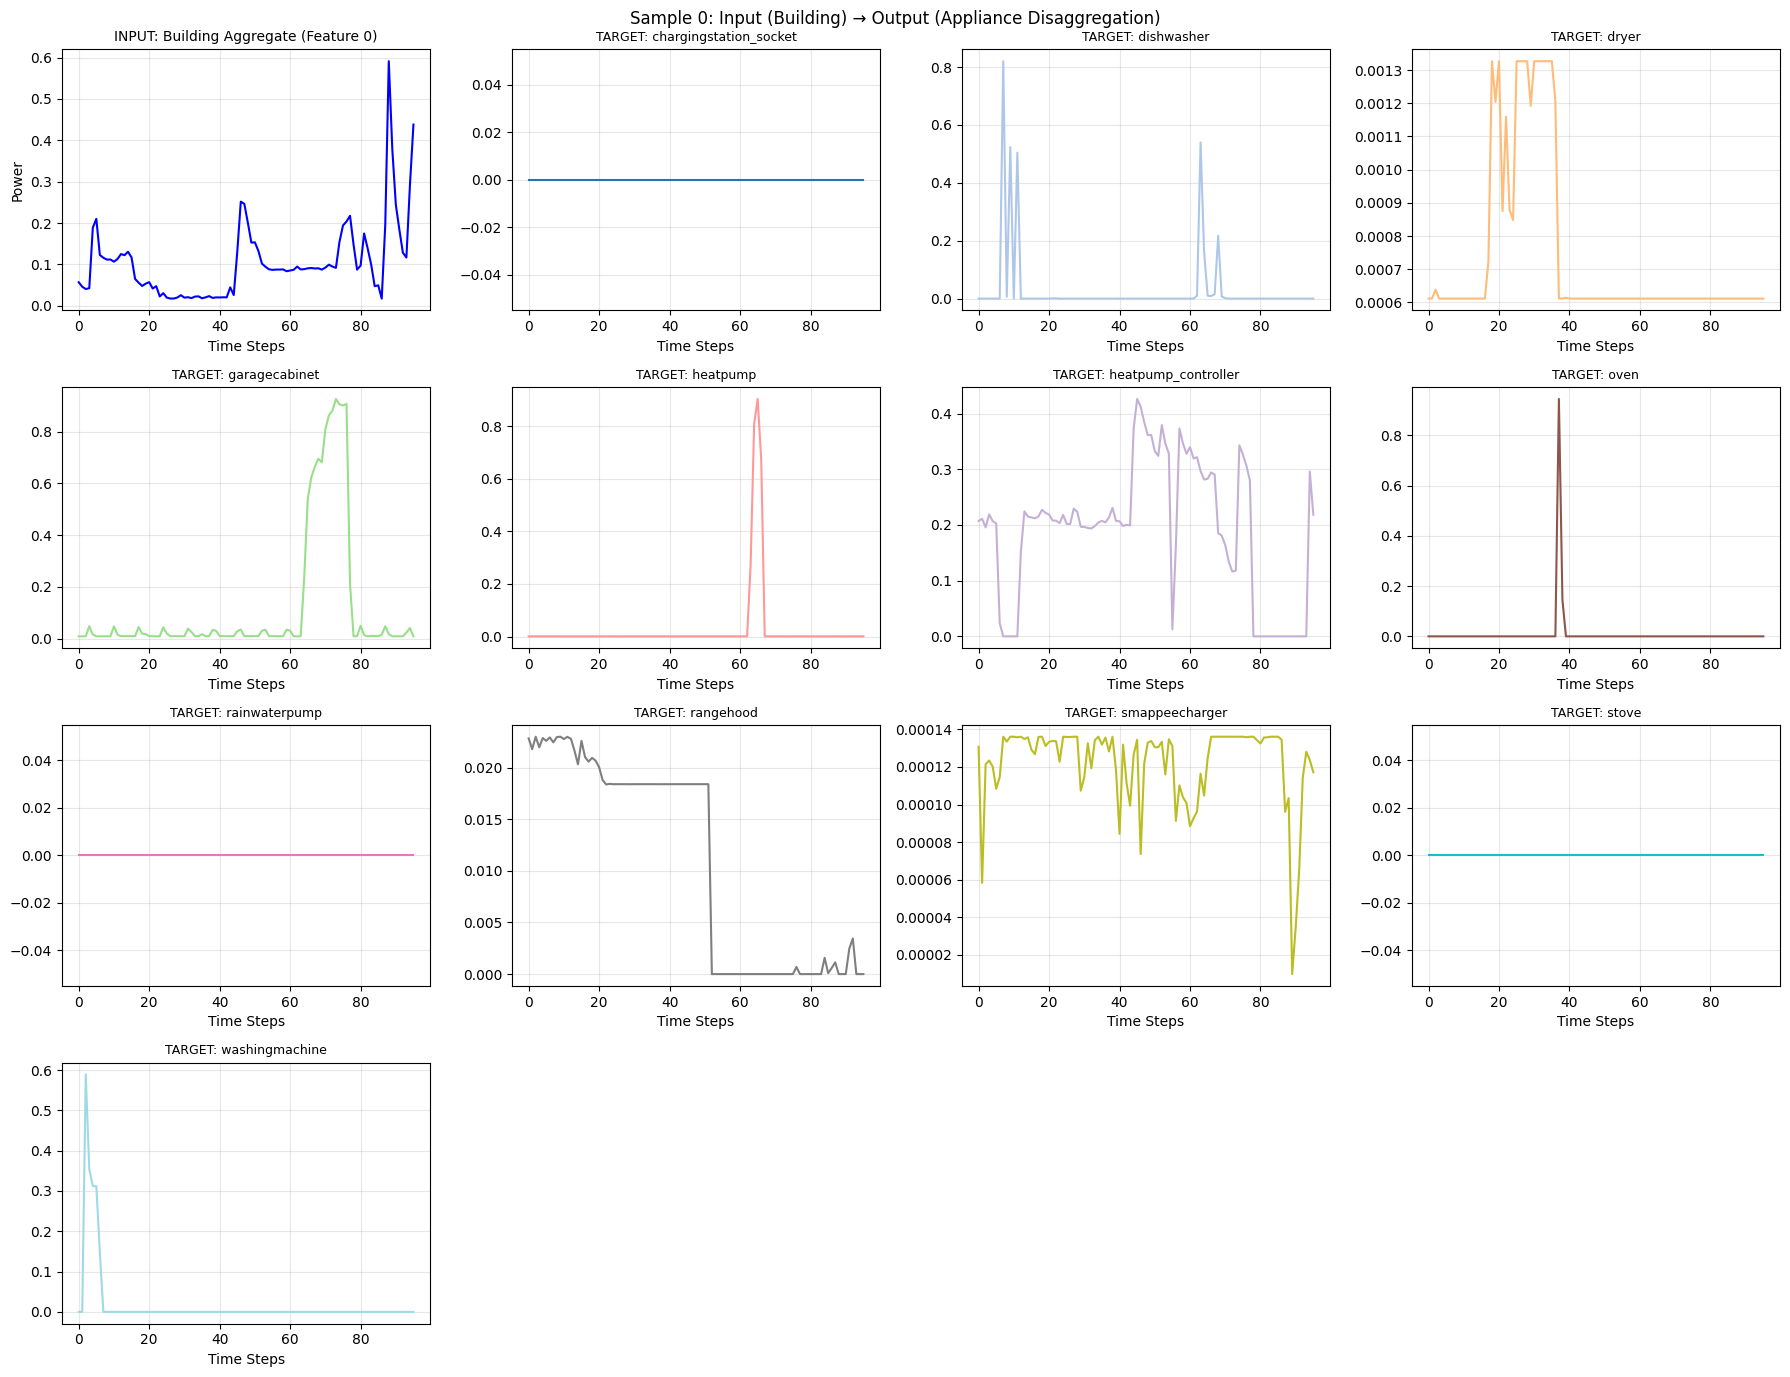

In [62]:
# Visualizza un sample con input e output per tutte le appliance
sample_idx = 0

fig, axes = plt.subplots(4, 4, figsize=(18, 14))
axes = axes.flatten()

# Plot dell'input (Feature 0 - Aggregate)
axes[0].plot(X_train[sample_idx, :, 0], color='blue', linewidth=1.5)
axes[0].set_title('INPUT: Building Aggregate (Feature 0)', fontsize=10)
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Power')
axes[0].grid(True, alpha=0.3)

# Plot dei target per ogni appliance
colors = plt.cm.tab20(np.linspace(0, 1, num_appliances))
for i, appliance in enumerate(APPLIANCES):
    ax_idx = i + 1
    if ax_idx < len(axes):
        axes[ax_idx].plot(Y_train[sample_idx, :, i], color=colors[i], linewidth=1.5)
        axes[ax_idx].set_title(f'TARGET: {appliance}', fontsize=9)
        axes[ax_idx].set_xlabel('Time Steps')
        axes[ax_idx].grid(True, alpha=0.3)

# Nascondi assi extra
for i in range(num_appliances + 1, len(axes)):
    axes[i].axis('off')

plt.suptitle(f'Sample {sample_idx}: Input (Building) → Output (Appliance Disaggregation)', fontsize=12)
plt.tight_layout()
plt.show()

## 4. Multi-Output CNN Model Definition

In [63]:
class SimpleAttention(nn.Module):
    def __init__(self, feature_dim):
        super(SimpleAttention, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(feature_dim)

    def forward(self, x):
        # x shape: (Batch, Channels, Length) -> (Batch, Length, Channels)
        x = x.transpose(1, 2)
        attn_output, _ = self.attn(x, x, x)
        x = self.norm(x + attn_output)
        return x.transpose(1, 2)


class MultiOutputCNNSeq2Seq(nn.Module):
    """
    CNN Multi-Output per predizione simultanea di tutte le appliance.
    Un encoder condiviso + branch separati per ogni appliance.
    """
    def __init__(self, input_channels=7, hidden_channels=48, num_layers=3, num_outputs=12):
        super().__init__()
        self.num_outputs = num_outputs

        # ---------- SHARED ENCODER ----------
        encoder_layers = []
        in_ch = input_channels

        for i in range(num_layers):
            out_ch = hidden_channels * (2 ** i)
            encoder_layers += [
                nn.Conv1d(in_ch, out_ch, kernel_size=5, padding=2),
                nn.BatchNorm1d(out_ch),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.25)
            ]
            in_ch = out_ch

        self.encoder = nn.Sequential(*encoder_layers)
        self.bottleneck_ch = hidden_channels * (2 ** (num_layers - 1))

        # ---------- ATTENTION ----------
        self.attention = SimpleAttention(self.bottleneck_ch)

        # ---------- SEPARATE DECODERS PER OGNI APPLIANCE ----------
        self.decoders = nn.ModuleList()
        self.output_layers = nn.ModuleList()
        
        for _ in range(num_outputs):
            # Decoder per ogni appliance
            decoder_layers = []
            in_ch = self.bottleneck_ch

            for i in reversed(range(num_layers)):
                out_ch = hidden_channels * (2 ** i) if i > 0 else hidden_channels
                decoder_layers += [
                    nn.Conv1d(in_ch, out_ch, kernel_size=5, padding=2),
                    nn.BatchNorm1d(out_ch),
                    nn.ReLU(),
                    nn.Dropout(0.2)
                ]
                in_ch = out_ch

            self.decoders.append(nn.Sequential(*decoder_layers))
            
            # Output layer per ogni appliance
            self.output_layers.append(nn.Sequential(
                nn.Conv1d(hidden_channels, 1, kernel_size=1),
                nn.ReLU()
            ))

    def forward(self, x):
        # x: (B, T, F) → (B, F, T)
        x = x.transpose(1, 2)

        # Shared encoding
        encoded = self.encoder(x)
        encoded = self.attention(encoded)

        # Separate decoding per ogni appliance
        outputs = []
        for decoder, output_layer in zip(self.decoders, self.output_layers):
            decoded = decoder(encoded)
            out = output_layer(decoded)
            outputs.append(out)

        # Stack outputs: (B, num_outputs, T) → (B, T, num_outputs)
        output = torch.cat(outputs, dim=1)  # (B, num_outputs, T)
        return output.transpose(1, 2)  # (B, T, num_outputs)


print("✓ MultiOutputCNNSeq2Seq definito")
print(f"  - Input channels: {num_input_features} features")
print(f"  - Output channels: {num_appliances} appliances")
print("  - Shared encoder + separate decoders per appliance")

✓ MultiOutputCNNSeq2Seq definito
  - Input channels: 7 features
  - Output channels: 12 appliances
  - Shared encoder + separate decoders per appliance


## 5. DataLoader Preparation

In [64]:
class MultiApplianceDataset(Dataset):
    def __init__(self, X, Y, device=None, augment=False, noise_std=0.01):
        self.X = torch.FloatTensor(X)
        self.Y = torch.FloatTensor(Y)
        
        if device is not None:
            self.X = self.X.to(device)
            self.Y = self.Y.to(device)
            
        self.device = device
        self.augment = augment
        self.noise_std = noise_std
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment and self.noise_std > 0:
            noise = torch.randn_like(x) * self.noise_std
            x = torch.clamp(x + noise, 0.0, 1.0)
        return x, self.Y[idx]

print("✓ MultiApplianceDataset definito")

✓ MultiApplianceDataset definito


In [65]:
# ===== CONFIGURAZIONE TRAINING =====
batch_size = 32
hidden_channels = 32
num_layers = 4
num_epochs = 150
learning_rate = 0.0008
noise_std = 0.015

# Dataset
train_dataset = MultiApplianceDataset(X_train, Y_train, device=device, augment=True, noise_std=noise_std)
val_dataset = MultiApplianceDataset(X_val, Y_val, device=device, augment=False)
test_dataset = MultiApplianceDataset(X_test, Y_test, device=device, augment=False)

use_pin_memory = (device.type == 'cpu')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=use_pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=use_pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=use_pin_memory)

print(f"Sequenze TRAINING: {len(X_train):,}")
print(f"Sequenze VALIDATION: {len(X_val):,}")
print(f"Sequenze TEST: {len(X_test):,}")
print(f"Device: {device}")

Sequenze TRAINING: 24,097
Sequenze VALIDATION: 5,377
Sequenze TEST: 5,281
Device: cuda


## 6. Multi-Output Loss Function

In [66]:
class MultiOutputNILMLoss(nn.Module):
    """
    Loss per NILM multi-output con focus sui picchi.
    Calcola la loss per ogni appliance e la somma.
    """
    def __init__(self, gamma=2.0, peak_weight=10.0, appliance_weights=None):
        super(MultiOutputNILMLoss, self).__init__()
        self.gamma = gamma
        self.peak_weight = peak_weight
        self.appliance_weights = appliance_weights  # Optional: weights per appliance
        
    def forward(self, pred, target):
        # pred, target: (B, T, num_appliances)
        total_loss = 0
        num_appliances = pred.shape[-1]
        
        for i in range(num_appliances):
            pred_i = pred[:, :, i:i+1]
            target_i = target[:, :, i:i+1]
            
            # MSE base
            mse = (pred_i - target_i) ** 2
            
            # Focal weighting
            focal_weight = (target_i ** self.gamma) * self.peak_weight + 1.0
            weighted_mse = (mse * focal_weight).mean()
            
            # Penalty for under-predictions
            under_pred = torch.clamp(target_i - pred_i, min=0)
            under_pred_penalty = (under_pred ** 2 * focal_weight).mean()
            
            appliance_loss = weighted_mse + under_pred_penalty
            
            # Peso opzionale per appliance
            if self.appliance_weights is not None:
                appliance_loss *= self.appliance_weights[i]
            
            total_loss += appliance_loss
        
        return total_loss / num_appliances

print("✓ MultiOutputNILMLoss definita")

✓ MultiOutputNILMLoss definita


In [67]:
# Setup modello
model = MultiOutputCNNSeq2Seq(
    input_channels=num_input_features, 
    hidden_channels=hidden_channels, 
    num_layers=num_layers,
    num_outputs=num_appliances
).to(device)

print(f"✓ Model created")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Input channels: {num_input_features}")
print(f"  Output channels: {num_appliances}")

# Loss and Optimizer
criterion = MultiOutputNILMLoss(gamma=2.0, peak_weight=10.0)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=6, factor=0.5)

print("✓ MultiOutputNILMLoss configured")
print("✓ ReduceLROnPlateau scheduler active")

✓ Modello creato
  Parametri: 7,011,596
  Input channels: 7
  Output channels: 12
✓ MultiOutputNILMLoss configurata
✓ ReduceLROnPlateau scheduler attivo


## 7. Training

In [68]:
# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience, patience_counter = 50, 0
lr_history = []

print(f"🚀 Training Multi-Output CNN ({num_epochs} epoche, early stopping patience={patience})")
print(f"   Output: {num_appliances} appliance predictions\n")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start = time.time()
    
    for inp, tgt in train_loader:
        inp, tgt = inp.to(device), tgt.to(device)
        
        pred = model(inp)
        loss = criterion(pred, tgt)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inp, tgt in val_loader:
            inp, tgt = inp.to(device), tgt.to(device)
            pred = model(inp)
            val_loss += criterion(pred, tgt).item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | LR: {current_lr:.6f} | {time.time()-start:.1f}s")
    
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        break

model.load_state_dict(best_model_state)
print(f"\n✓ Training completed! Best validation loss: {best_val_loss:.6f}")

🚀 Training Multi-Output CNN (150 epoche, early stopping patience=50)
   Output: 12 appliance predictions

Epoch  10 | Train Loss: 0.107984 | Val Loss: 0.119989 | LR: 0.000800 | 60.1s


KeyboardInterrupt: 

## 8. Training Visualization

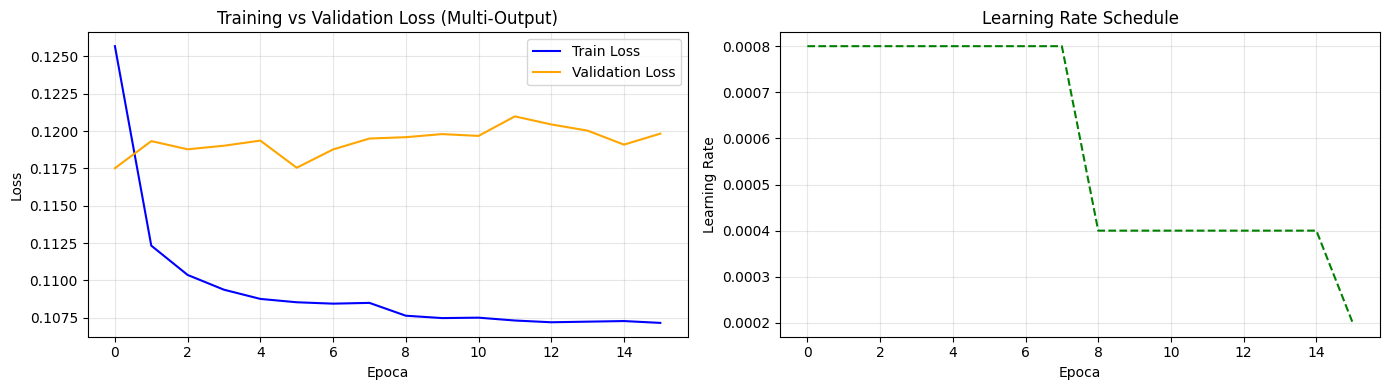

Train Loss: 0.1257 → 0.1072
Val Loss: 0.1175 → 0.1198 (best: 0.1175)


In [ ]:
# Plot training e validation loss
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(train_losses, label='Train Loss', color='blue')
axes[0].plot(val_losses, label='Validation Loss', color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss (Multi-Output)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning Rate
axes[1].plot(lr_history, linestyle='--', color='green', label='Learning Rate')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Train Loss: {train_losses[0]:.4f} → {train_losses[-1]:.4f}")
print(f"Val Loss: {val_losses[0]:.4f} → {val_losses[-1]:.4f} (best: {best_val_loss:.4f})")

## 9. Evaluation su Test Set

In [ ]:
# Valutazione su test set per ogni appliance
model.eval()

all_preds = []
all_actuals = []

with torch.no_grad():
    for inp, tgt in test_loader:
        inp = inp.to(device)
        pred = model(inp).cpu().numpy()
        all_preds.append(pred)
        all_actuals.append(tgt.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_actuals = np.concatenate(all_actuals, axis=0)

print(f"Predictions shape: {all_preds.shape}")
print(f"Actuals shape: {all_actuals.shape}")

Predictions shape: (5281, 96, 12)
Actuals shape: (5281, 96, 12)


In [ ]:
# Calcola metriche per ogni appliance
print("=" * 70)
print(f"{'Appliance':<25} {'MSE':>12} {'MAE':>12} {'R²':>12}")
print("=" * 70)

metrics_per_appliance = {}

for i, appliance in enumerate(APPLIANCES):
    pred_flat = all_preds[:, :, i].flatten()
    actual_flat = all_actuals[:, :, i].flatten()
    
    mse = mean_squared_error(actual_flat, pred_flat)
    mae = mean_absolute_error(actual_flat, pred_flat)
    r2 = r2_score(actual_flat, pred_flat)
    
    metrics_per_appliance[appliance] = {'mse': mse, 'mae': mae, 'r2': r2}
    print(f"{appliance:<25} {mse:>12.6f} {mae:>12.6f} {r2:>12.4f}")

print("=" * 70)

# Metriche medie
avg_mse = np.mean([m['mse'] for m in metrics_per_appliance.values()])
avg_mae = np.mean([m['mae'] for m in metrics_per_appliance.values()])
avg_r2 = np.mean([m['r2'] for m in metrics_per_appliance.values()])
print(f"{'AVERAGE':<25} {avg_mse:>12.6f} {avg_mae:>12.6f} {avg_r2:>12.4f}")

Appliance                          MSE          MAE           R²
chargingstation_socket        0.015223     0.036830      -0.0101
dishwasher                    0.014842     0.107744      -0.7783
dryer                         0.000653     0.001635      -0.0041
garagecabinet                 0.130331     0.339939      -1.2699
heatpump                      0.159993     0.377275      -1.4088
heatpump_controller           0.335080     0.544533      -1.8733
oven                          0.012861     0.100428      -1.3474
rainwaterpump                 0.000941     0.001215      -0.0016
rangehood                     0.000182     0.006944      -0.0334
smappeecharger                0.012984     0.096938      -0.4007
stove                         0.001471     0.004135      -0.0118
washingmachine                0.012236     0.098626      -0.6676
AVERAGE                       0.058066     0.143020      -0.6506


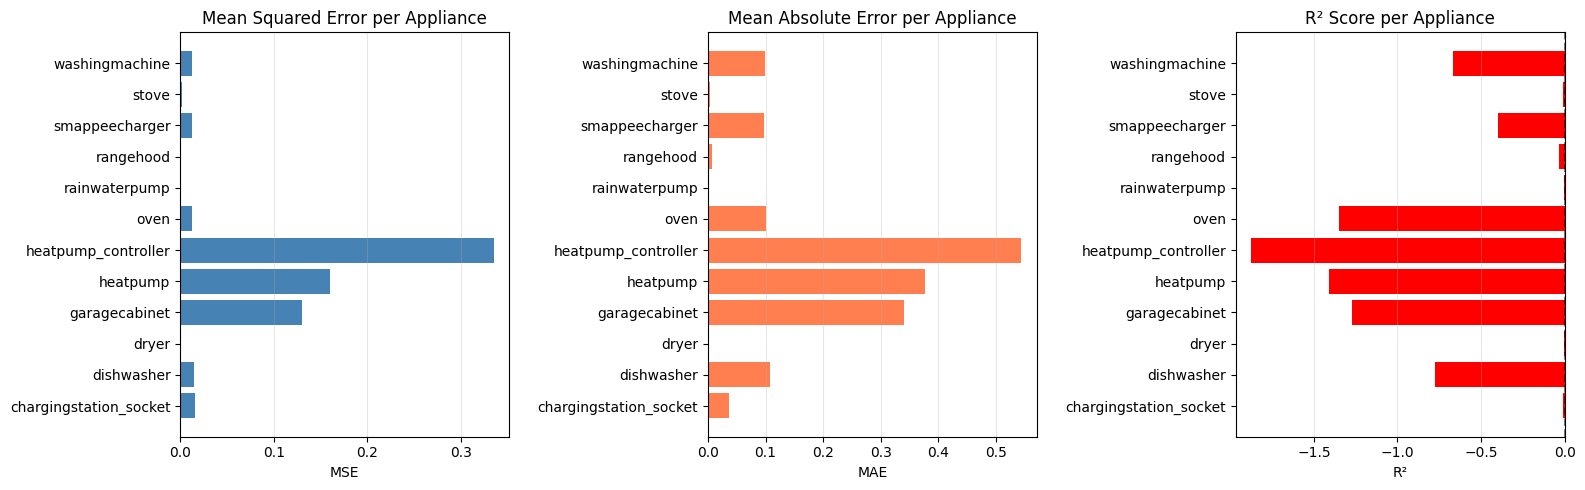

In [ ]:
# Visualizza le metriche
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Bar plot MSE
mse_values = [metrics_per_appliance[a]['mse'] for a in APPLIANCES]
axes[0].barh(APPLIANCES, mse_values, color='steelblue')
axes[0].set_xlabel('MSE')
axes[0].set_title('Mean Squared Error per Appliance')
axes[0].grid(True, alpha=0.3, axis='x')

# Bar plot MAE
mae_values = [metrics_per_appliance[a]['mae'] for a in APPLIANCES]
axes[1].barh(APPLIANCES, mae_values, color='coral')
axes[1].set_xlabel('MAE')
axes[1].set_title('Mean Absolute Error per Appliance')
axes[1].grid(True, alpha=0.3, axis='x')

# Bar plot R²
r2_values = [metrics_per_appliance[a]['r2'] for a in APPLIANCES]
colors = ['green' if v > 0.5 else 'orange' if v > 0 else 'red' for v in r2_values]
axes[2].barh(APPLIANCES, r2_values, color=colors)
axes[2].set_xlabel('R²')
axes[2].set_title('R² Score per Appliance')
axes[2].axvline(x=0, color='black', linestyle='--', alpha=0.5)
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 10. Predictions Visualization

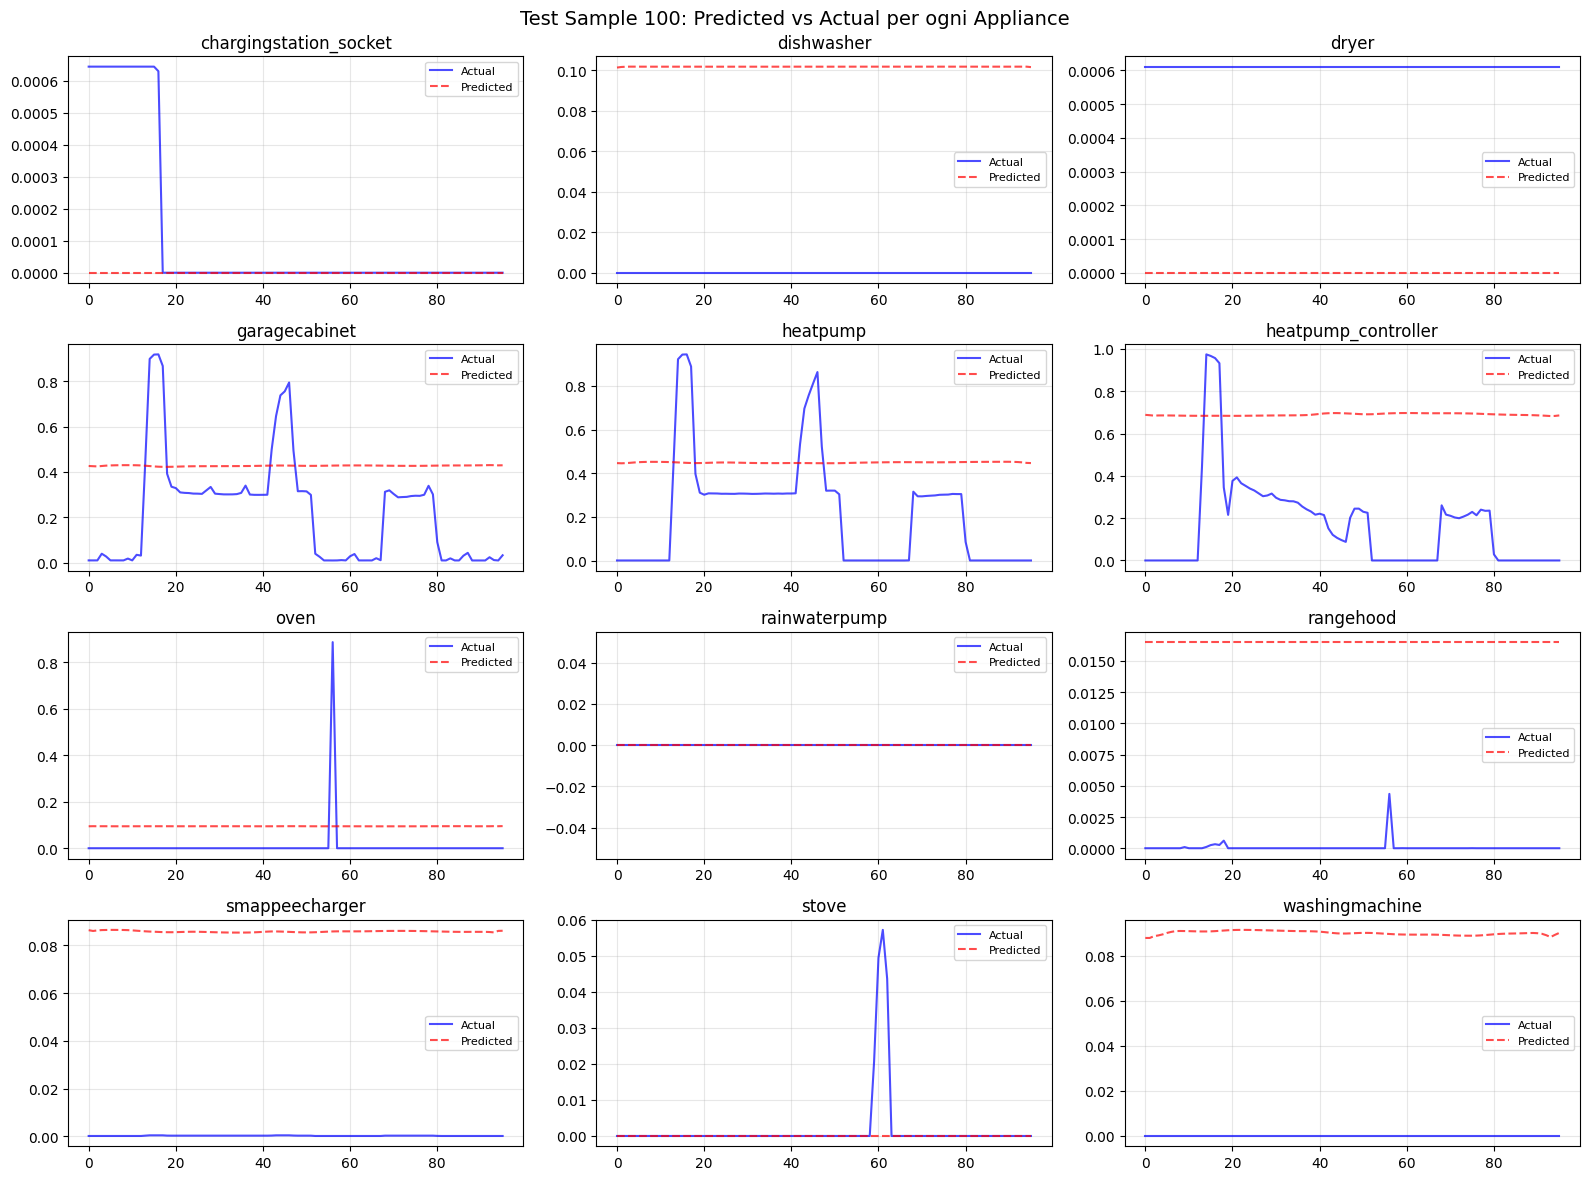

In [ ]:
# Visualize predictions vs actual for a specific sample
test_idx = 100  # Change to see other samples

with torch.no_grad():
    inp = torch.FloatTensor(X_test[test_idx]).unsqueeze(0).to(device)
    pred = model(inp).cpu().numpy().squeeze()
    actual = Y_test[test_idx]

# Plot per ogni appliance
n_cols = 3
n_rows = (num_appliances + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3*n_rows))
axes = axes.flatten()

for i, appliance in enumerate(APPLIANCES):
    axes[i].plot(actual[:, i], label='Actual', color='blue', alpha=0.7)
    axes[i].plot(pred[:, i], label='Predicted', color='red', alpha=0.7, linestyle='--')
    axes[i].set_title(f'{appliance}')
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

# Nascondi assi extra
for i in range(num_appliances, len(axes)):
    axes[i].axis('off')

plt.suptitle(f'Test Sample {test_idx}: Predicted vs Actual for each Appliance', fontsize=14)
plt.tight_layout()
plt.show()

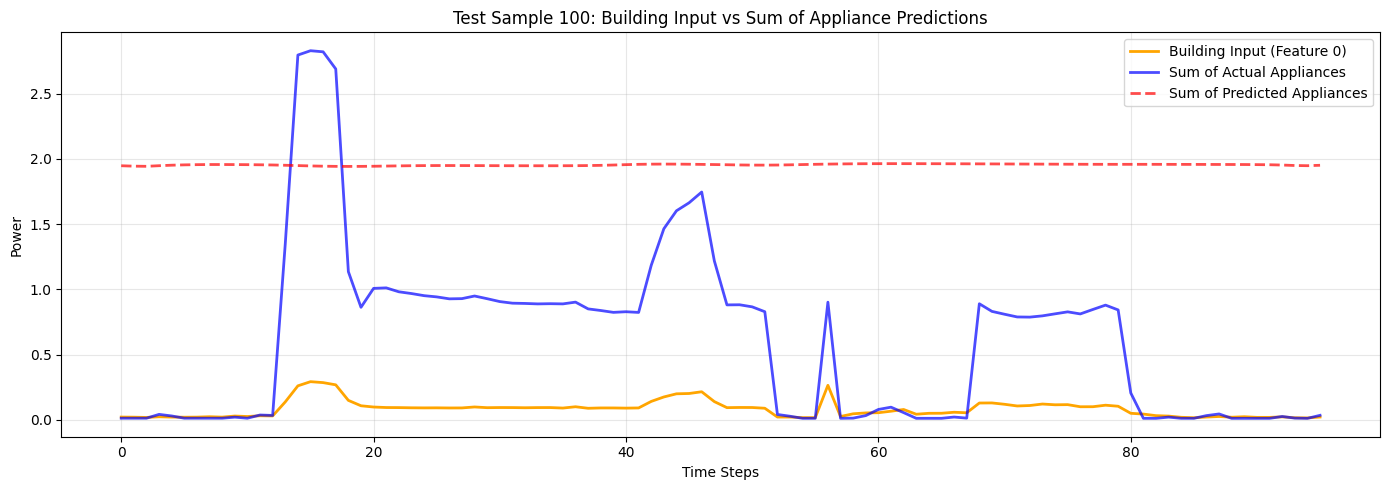


Metriche Somma Appliance (Sample 100):
  MSE: 2.245560 | MAE: 1.411148 | R²: -4.0628


In [ ]:
# Confronto Input Building vs Somma Predizioni
test_idx = 100

with torch.no_grad():
    inp = torch.FloatTensor(X_test[test_idx]).unsqueeze(0).to(device)
    pred = model(inp).cpu().numpy().squeeze()
    actual = Y_test[test_idx]

# Somma delle predizioni di tutte le appliance
sum_predicted = pred.sum(axis=1)
sum_actual = actual.sum(axis=1)

# Input building (Feature 0)
building_input = X_test[test_idx, :, 0]

plt.figure(figsize=(14, 5))
plt.plot(building_input, label='Building Input (Feature 0)', color='orange', linewidth=2)
plt.plot(sum_actual, label='Sum of Actual Appliances', color='blue', linewidth=2, alpha=0.7)
plt.plot(sum_predicted, label='Sum of Predicted Appliances', color='red', linewidth=2, linestyle='--', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Power')
plt.title(f'Test Sample {test_idx}: Building Input vs Sum of Appliance Predictions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Metrics for the sum
sum_mse = mean_squared_error(sum_actual, sum_predicted)
sum_mae = mean_absolute_error(sum_actual, sum_predicted)
sum_r2 = r2_score(sum_actual, sum_predicted)

print(f"\nAppliance Sum Metrics (Sample {test_idx}):")
print(f"  MSE: {sum_mse:.6f} | MAE: {sum_mae:.6f} | R²: {sum_r2:.4f}")

## 11. Model Saving

In [ ]:
# Salva il modello
model_dir = os.path.join("..", "models")
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, "multi_output_cnn_all_appliances.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparameters': {
        'hidden_channels': hidden_channels,
        'num_layers': num_layers,
        'window_size': window_size,
        'num_input_features': num_input_features,
        'num_outputs': num_appliances,
        'appliances': APPLIANCES
    },
    'train_losses': train_losses,
    'val_losses': val_losses,
    'best_val_loss': best_val_loss,
    'metrics_per_appliance': metrics_per_appliance
}, model_path)

print(f"✓ Model saved: {model_path}")

✓ Modello salvato: ..\models\multi_output_cnn_all_appliances.pth


## 12. Final Summary

In [ ]:
print("\n" + "=" * 70)
print("                    MULTI-OUTPUT MODEL SUMMARY")
print("=" * 70)
print(f"\n📊 Dataset:")
print(f"   - Train samples: {len(X_train):,}")
print(f"   - Val samples: {len(X_val):,}")
print(f"   - Test samples: {len(X_test):,}")
print(f"   - Window size: {window_size}")
print(f"   - Input features: {num_input_features}")

print(f"\n🏗️ Architecture:")
print(f"   - Encoder: Shared CNN with {num_layers} layers")
print(f"   - Bottleneck: {hidden_channels * (2 ** (num_layers - 1))} channels + Attention")
print(f"   - Decoders: {num_appliances} separate branches")
print(f"   - Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\n📈 Performance:")
print(f"   - Best Val Loss: {best_val_loss:.6f}")
print(f"   - Average Test MSE: {avg_mse:.6f}")
print(f"   - Average Test MAE: {avg_mae:.6f}")
print(f"   - Average Test R²: {avg_r2:.4f}")

print(f"\n🎯 Best performing appliances (by R²):")
sorted_apps = sorted(metrics_per_appliance.items(), key=lambda x: x[1]['r2'], reverse=True)
for app, m in sorted_apps[:5]:
    print(f"   - {app}: R² = {m['r2']:.4f}")

print(f"\n⚠️ Worst performing appliances (by R²):")
for app, m in sorted_apps[-3:]:
    print(f"   - {app}: R² = {m['r2']:.4f}")

print("\n" + "=" * 70)


                    RIEPILOGO MULTI-OUTPUT MODEL

📊 Dataset:
   - Train samples: 24,097
   - Val samples: 5,377
   - Test samples: 5,281
   - Window size: 96
   - Input features: 7

🏗️ Architettura:
   - Encoder: Shared CNN con 4 layers
   - Bottleneck: 256 channels + Attention
   - Decoders: 12 branch separati
   - Parametri totali: 7,011,596

📈 Performance:
   - Best Val Loss: 0.117518
   - Average Test MSE: 0.058066
   - Average Test MAE: 0.143020
   - Average Test R²: -0.6506

🎯 Best performing appliances (by R²):
   - rainwaterpump: R² = -0.0016
   - dryer: R² = -0.0041
   - chargingstation_socket: R² = -0.0101
   - stove: R² = -0.0118
   - rangehood: R² = -0.0334

⚠️ Worst performing appliances (by R²):
   - oven: R² = -1.3474
   - heatpump: R² = -1.4088
   - heatpump_controller: R² = -1.8733

